## Overview

Not all layers in a neural network respond equally to compression. Some layers are robust and can be heavily compressed with minimal impact, while others are fragile and degrade quickly. **Sensitivity analysis** helps you identify which layers fall into each category.

This tutorial shows you how to:
1. Analyze layer sensitivity to different compression methods
2. Identify fragile vs robust layers
3. Generate non-uniform compression schedules based on sensitivity

In [1]:
#| include: false
import torch
import torch.nn as nn
from torchvision.models import resnet18
from fasterai.analysis.sensitivity import SensitivityAnalyzer, analyze_sensitivity
from fasterai.core.all import large_final

## 1. Setup

First, we need a model and an evaluation function. The evaluation function takes a model and returns a metric (e.g., accuracy, loss).

In [2]:
# Load a pretrained model
model = resnet18(pretrained=True)
model.eval()

# Create sample input
sample = torch.randn(1, 3, 224, 224)

# Define an evaluation function
# In practice, this would evaluate on your validation set
def eval_fn(m):
    """Simple proxy: measure output magnitude (replace with real accuracy)"""
    with torch.no_grad():
        out = m(sample)
        return out.abs().mean().item()

/home/nathan/miniconda3/envs/dev/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nathan/miniconda3/envs/dev/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 2. Basic Sensitivity Analysis

The simplest way to run sensitivity analysis is with the `analyze_sensitivity()` function:

In [3]:
result = analyze_sensitivity(
    model, 
    sample, 
    eval_fn,
    compression="sparsity",  # "sparsity", "pruning", or "quantization"
    level=50,                 # 50% sparsity
)

Computing baseline accuracy... 1.2251
Analyzing 21 layers for sparsity @ 50% (granularity=weight, criteria=abs)
  [1/21] conv1... Δ=-0.0044
  [2/21] layer1.0.conv1... Δ=-0.0989
  [3/21] layer1.0.conv2... Δ=-0.0566
  [4/21] layer1.1.conv1... Δ=-0.0658
  [5/21] layer1.1.conv2... Δ=+0.0489
  [6/21] layer2.0.conv1... Δ=-0.1026
  [7/21] layer2.0.conv2... Δ=-0.0745
  [8/21] layer2.0.downsample.0... Δ=-0.1521
  [9/21] layer2.1.conv1... Δ=-0.1118
  [10/21] layer2.1.conv2... Δ=+0.0280
  [11/21] layer3.0.conv1... Δ=-0.0746
  [12/21] layer3.0.conv2... Δ=+0.0295
  [13/21] layer3.0.downsample.0... Δ=+0.0013
  [14/21] layer3.1.conv1... Δ=-0.0096
  [15/21] layer3.1.conv2... Δ=-0.0644
  [16/21] layer4.0.conv1... Δ=-0.0740
  [17/21] layer4.0.conv2... Δ=+0.0412
  [18/21] layer4.0.downsample.0... Δ=+0.0306
  [19/21] layer4.1.conv1... Δ=-0.0117
  [20/21] layer4.1.conv2... Δ=-0.0857
  [21/21] fc... Δ=+0.0615
✓ Analysis complete


## 3. Understanding the Results

The `SensitivityResult` object provides several ways to inspect the results:

In [4]:
# Print a formatted summary
result.summary()

════════════════════════════════════════════════════════════
Sensitivity Analysis: sparsity @ 50%
════════════════════════════════════════════════════════════
  Baseline accuracy: 1.2251
  Layers analyzed: 21

  🔴 Most Sensitive (fragile):
     1. fc                             Δ=+0.0615
     2. layer1.1.conv2                 Δ=+0.0489
     3. layer4.0.conv2                 Δ=+0.0412
     4. layer4.0.downsample.0          Δ=+0.0306
     5. layer3.0.conv2                 Δ=+0.0295

  🟢 Most Robust (compressible):
     1. layer2.0.downsample.0          Δ=-0.1521
     2. layer2.1.conv1                 Δ=-0.1118
     3. layer2.0.conv1                 Δ=-0.1026
     4. layer1.0.conv1                 Δ=-0.0989
     5. layer4.1.conv2                 Δ=-0.0857


In [5]:
# Get the top 3 most sensitive layers
fragile = result.top(3, most_sensitive=True)
for layer in fragile:
    print(f"{layer.name}: Δ={layer.delta:.4f}")

fc: Δ=0.0615
layer1.1.conv2: Δ=0.0489
layer4.0.conv2: Δ=0.0412


In [6]:
# Get the top 3 most robust layers (safe to compress heavily)
robust = result.top(3, most_sensitive=False)
for layer in robust:
    print(f"{layer.name}: Δ={layer.delta:.4f}")

layer2.0.downsample.0: Δ=-0.1521
layer2.1.conv1: Δ=-0.1118
layer2.0.conv1: Δ=-0.1026


## 4. Visualizing Sensitivity

A bar chart helps visualize which layers are most sensitive:

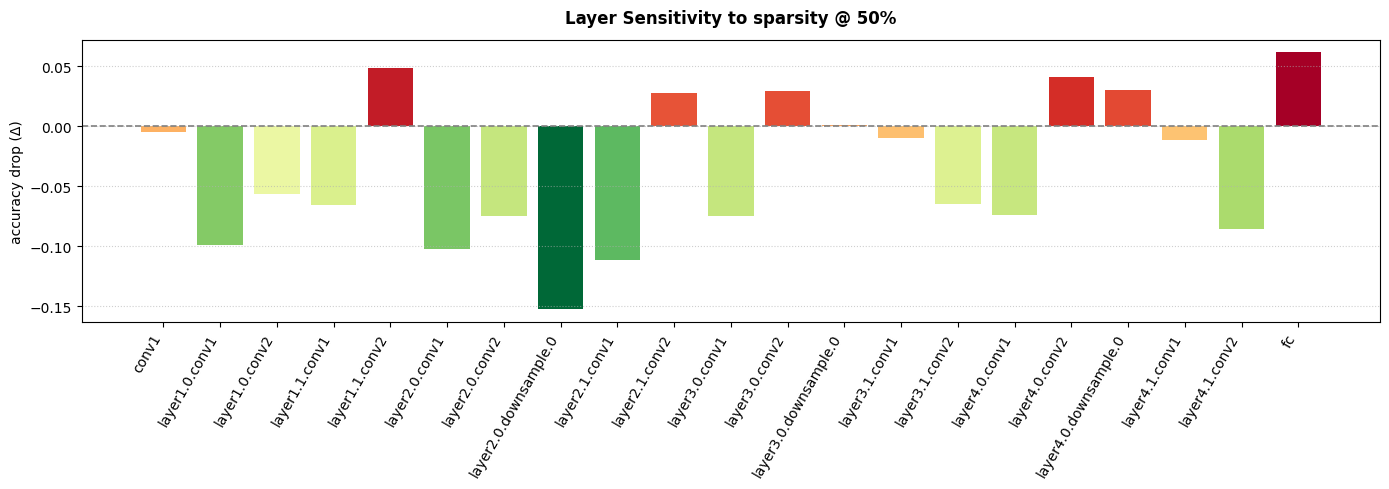

In [7]:
result.plot(figsize=(14, 5))

## 5. Creating Non-Uniform Compression Schedules

The key insight from sensitivity analysis is that you shouldn't compress all layers equally. Use `to_schedule()` to generate a non-uniform compression schedule:

In [8]:
schedule = result.to_schedule(
    model,
    target_pct=50,   # Target 50% average compression
    min_pct=10,      # No layer below 10%
    max_pct=80,      # No layer above 80%
    gamma=1.5,       # Higher = more differentiation between layers
)

# Show a few entries
for name, sparsity in list(schedule.items())[:5]:
    print(f"{name}: {sparsity}%")

conv1: 67.41%
layer1.0.conv1: 67.41%
layer1.0.conv2: 67.41%
layer1.1.conv1: 67.41%
layer1.1.conv2: 10.0%


## 6. Applying the Schedule with Sparsifier

The schedule generated by `to_schedule()` can be directly used with fasterai's `Sparsifier` to apply non-uniform compression:

In [ ]:
from fasterai.sparse.all import Sparsifier

# 1. Run sensitivity analysis
result = analyze_sensitivity(model, sample, eval_fn, compression="sparsity", level=50)

# 2. Generate the schedule (layer_name -> sparsity %)
schedule = result.to_schedule(model, target_pct=50, min_pct=10, max_pct=80)

# 3. Create a fresh model and Sparsifier
model = resnet18(pretrained=True)
sparsifier = Sparsifier(model, granularity='weight', context='local', criteria=large_final)

# 4. Apply non-uniform sparsity using the schedule
for name, module in model.named_modules():
    if name in schedule:
        sparsifier.sparsify_layer(module, schedule[name])
        
# 5. Check the results
sparsifier.print_sparsity()

```
Sparsity Report:
--------------------------------------------------------------------------------
Layer                Type            Params     Zeros      Sparsity  
--------------------------------------------------------------------------------
conv1                Conv2d          9,408      6,350         67.50%
layer1.0.conv1       Conv2d          36,864     24,883        67.50%
layer1.0.conv2       Conv2d          36,864     24,883        67.50%
layer1.1.conv1       Conv2d          36,864     24,883        67.50%
layer1.1.conv2       Conv2d          36,864     3,686         10.00%  <- fragile layer
...
layer4.1.conv2       Conv2d          2,359,296  1,887,436     80.00%  <- robust layer
--------------------------------------------------------------------------------
Overall              all             11,166,912 5,583,456     50.00%  <- hits target!
```

Notice how fragile layers get low sparsity (10%) while robust layers get high sparsity (80%), but the overall average hits the 50% target.

### Using with Pruner (Structural Pruning)

For structural pruning, you can use the schedule with the `Pruner` class. Note that structural pruning removes entire filters, so the schedule represents the percentage of filters to remove:

In [ ]:
from fasterai.prune.all import Pruner

# 1. Analyze sensitivity to pruning
result = analyze_sensitivity(model, sample, eval_fn, compression="pruning", level=30)

# 2. Generate schedule
schedule = result.to_schedule(model, target_pct=30, min_pct=5, max_pct=50)

# 3. Create Pruner with the schedule as layer-wise pruning ratios
model = resnet18(pretrained=True)
pruner = Pruner(
    model,
    example_inputs=sample,
    pruning_ratio=schedule,  # Pass the schedule directly!
    context='local',
    criteria=large_final,
)

# 4. Prune the model
pruner.prune_model()
pruner.print_sparsity()

> **Tip**: The workflow is:
> 1. **Analyze** → Find which layers are sensitive
> 2. **Schedule** → Generate non-uniform compression ratios  
> 3. **Apply** → Use Sparsifier or Pruner with the schedule
> 4. **Fine-tune** → Retrain to recover accuracy (optional but recommended)

## 7. Using SensitivityAnalyzer for More Control

In [9]:
analyzer = SensitivityAnalyzer(
    model,
    sample,
    eval_fn,
    criteria=large_final,       # Importance scoring method
    higher_is_better=True,      # Higher metric = better
    metric_name="accuracy",     # For display
)

# Analyze sparsity sensitivity
sparsity_result = analyzer.analyze(
    compression="sparsity",
    level=50,
    granularity="weight",  # or "filter", "kernel", etc.
)

Computing baseline accuracy... 1.2251
Analyzing 21 layers for sparsity @ 50% (granularity=weight, criteria=abs)
  [1/21] conv1... Δ=-0.0044
  [2/21] layer1.0.conv1... Δ=-0.0989
  [3/21] layer1.0.conv2... Δ=-0.0566
  [4/21] layer1.1.conv1... Δ=-0.0658
  [5/21] layer1.1.conv2... Δ=+0.0489
  [6/21] layer2.0.conv1... Δ=-0.1026
  [7/21] layer2.0.conv2... Δ=-0.0745
  [8/21] layer2.0.downsample.0... Δ=-0.1521
  [9/21] layer2.1.conv1... Δ=-0.1118
  [10/21] layer2.1.conv2... Δ=+0.0280
  [11/21] layer3.0.conv1... Δ=-0.0746
  [12/21] layer3.0.conv2... Δ=+0.0295
  [13/21] layer3.0.downsample.0... Δ=+0.0013
  [14/21] layer3.1.conv1... Δ=-0.0096
  [15/21] layer3.1.conv2... Δ=-0.0644
  [16/21] layer4.0.conv1... Δ=-0.0740
  [17/21] layer4.0.conv2... Δ=+0.0412
  [18/21] layer4.0.downsample.0... Δ=+0.0306
  [19/21] layer4.1.conv1... Δ=-0.0117
  [20/21] layer4.1.conv2... Δ=-0.0857
  [21/21] fc... Δ=+0.0615
✓ Analysis complete


## 8. Different Compression Types

In [10]:
sparsity_result = analyzer.analyze(
    compression="sparsity",
    level=50,                # 50% of weights zeroed
    granularity="weight",    # Unstructured sparsity
)

Computing baseline accuracy... 1.2251
Analyzing 21 layers for sparsity @ 50% (granularity=weight, criteria=abs)
  [1/21] conv1... Δ=-0.0044
  [2/21] layer1.0.conv1... Δ=-0.0989
  [3/21] layer1.0.conv2... Δ=-0.0566
  [4/21] layer1.1.conv1... Δ=-0.0658
  [5/21] layer1.1.conv2... Δ=+0.0489
  [6/21] layer2.0.conv1... Δ=-0.1026
  [7/21] layer2.0.conv2... Δ=-0.0745
  [8/21] layer2.0.downsample.0... Δ=-0.1521
  [9/21] layer2.1.conv1... Δ=-0.1118
  [10/21] layer2.1.conv2... Δ=+0.0280
  [11/21] layer3.0.conv1... Δ=-0.0746
  [12/21] layer3.0.conv2... Δ=+0.0295
  [13/21] layer3.0.downsample.0... Δ=+0.0013
  [14/21] layer3.1.conv1... Δ=-0.0096
  [15/21] layer3.1.conv2... Δ=-0.0644
  [16/21] layer4.0.conv1... Δ=-0.0740
  [17/21] layer4.0.conv2... Δ=+0.0412
  [18/21] layer4.0.downsample.0... Δ=+0.0306
  [19/21] layer4.1.conv1... Δ=-0.0117
  [20/21] layer4.1.conv2... Δ=-0.0857
  [21/21] fc... Δ=+0.0615
✓ Analysis complete


### Structural Pruning (Filter Removal)

In [11]:
pruning_result = analyzer.analyze(
    compression="pruning",
    level=30,                # 30% of filters removed
)

Computing baseline accuracy... 1.2251
Analyzing 21 layers for pruning @ 30% (structural, criteria=abs)
  [1/21] conv1... Δ=0.0000
  [2/21] layer1.0.conv1... Δ=-0.0281
  [3/21] layer1.0.conv2... Δ=0.0000
  [4/21] layer1.1.conv1... Δ=-0.2027
  [5/21] layer1.1.conv2... Δ=0.0000
  [6/21] layer2.0.conv1... Δ=-0.3118
  [7/21] layer2.0.conv2... Δ=0.0000
  [8/21] layer2.0.downsample.0... Δ=0.0000
  [9/21] layer2.1.conv1... Δ=-0.3897
  [10/21] layer2.1.conv2... Δ=0.0000
  [11/21] layer3.0.conv1... Δ=+0.1169
  [12/21] layer3.0.conv2... Δ=0.0000
  [13/21] layer3.0.downsample.0... Δ=0.0000
  [14/21] layer3.1.conv1... Δ=-0.1139
  [15/21] layer3.1.conv2... Δ=0.0000
  [16/21] layer4.0.conv1... Δ=+0.1821
  [17/21] layer4.0.conv2... Δ=0.0000
  [18/21] layer4.0.downsample.0... Δ=0.0000
  [19/21] layer4.1.conv1... Δ=-0.3104
  [20/21] layer4.1.conv2... Δ=0.0000
  [21/21] fc... Δ=-0.0286
✓ Analysis complete


### Quantization (Precision Reduction)

In [12]:
quant_result = analyzer.analyze(
    compression="quantization",
    level=8,                     # 8-bit quantization
    quant_per_channel=True,      # Per-channel quantization
    quant_activations=False,     # Weights only
)

Computing baseline accuracy... 1.2251
Analyzing 21 layers for quantization @ 8bits (per-channel, weights only)
  [1/21] conv1... Δ=-0.0008
  [2/21] layer1.0.conv1... Δ=-0.0018
  [3/21] layer1.0.conv2... Δ=-0.0021
  [4/21] layer1.1.conv1... Δ=-0.0019
  [5/21] layer1.1.conv2... Δ=-0.0011
  [6/21] layer2.0.conv1... Δ=-0.0053
  [7/21] layer2.0.conv2... Δ=-0.0026
  [8/21] layer2.0.downsample.0... Δ=-0.0022
  [9/21] layer2.1.conv1... Δ=-0.0098
  [10/21] layer2.1.conv2... Δ=-0.0010
  [11/21] layer3.0.conv1... Δ=+0.0024
  [12/21] layer3.0.conv2... Δ=+0.0018
  [13/21] layer3.0.downsample.0... Δ=-0.0012
  [14/21] layer3.1.conv1... Δ=-0.0019
  [15/21] layer3.1.conv2... Δ=-0.0015
  [16/21] layer4.0.conv1... Δ=+0.0003
  [17/21] layer4.0.conv2... Δ=+0.0015
  [18/21] layer4.0.downsample.0... Δ=-0.0023
  [19/21] layer4.1.conv1... Δ=-0.0015
  [20/21] layer4.1.conv2... Δ=+0.0001
  [21/21] fc... Δ=+0.0003
✓ Analysis complete


## 9. Sweeping Multiple Compression Levels

In [13]:
results = analyzer.sweep(
    compression="sparsity",
    levels=[25, 50, 75],
)


Sweep: sparsity @ 25%
Computing baseline accuracy... 1.2251
Analyzing 21 layers for sparsity @ 25% (granularity=weight, criteria=abs)
  [1/21] conv1... Δ=-0.0017
  [2/21] layer1.0.conv1... Δ=+0.0090
  [3/21] layer1.0.conv2... Δ=-0.0075
  [4/21] layer1.1.conv1... Δ=-0.0173
  [5/21] layer1.1.conv2... Δ=+0.0098
  [6/21] layer2.0.conv1... Δ=+0.0362
  [7/21] layer2.0.conv2... Δ=+0.0035
  [8/21] layer2.0.downsample.0... Δ=-0.0335
  [9/21] layer2.1.conv1... Δ=+0.0013
  [10/21] layer2.1.conv2... Δ=+0.0167
  [11/21] layer3.0.conv1... Δ=-0.0063
  [12/21] layer3.0.conv2... Δ=-0.0067
  [13/21] layer3.0.downsample.0... Δ=+0.0021
  [14/21] layer3.1.conv1... Δ=-0.0190
  [15/21] layer3.1.conv2... Δ=-0.0044
  [16/21] layer4.0.conv1... Δ=-0.0003
  [17/21] layer4.0.conv2... Δ=+0.0054
  [18/21] layer4.0.downsample.0... Δ=+0.0068
  [19/21] layer4.1.conv1... Δ=-0.0188
  [20/21] layer4.1.conv2... Δ=-0.0116
  [21/21] fc... Δ=+0.0169
✓ Analysis complete

Sweep: sparsity @ 50%
Computing baseline accuracy... 1.

## 10. Exporting Results

In [14]:
df = result.to_dataframe()
df.head()

,name,layer_type,params,baseline_metric,compressed_metric,delta
0,conv1,Conv2d,9408,1.225066,1.229451,-0.004385
1,layer1.0.conv1,Conv2d,36864,1.225066,1.323971,-0.098906
2,layer1.0.conv2,Conv2d,36864,1.225066,1.281706,-0.056640
3,layer1.1.conv1,Conv2d,36864,1.225066,1.290877,-0.065811
4,layer1.1.conv2,Conv2d,36864,1.225066,1.176173,0.048893


---

## Summary

| Function/Method | Purpose |
|-----------------|--------|
| `analyze_sensitivity()` | One-line sensitivity analysis |
| `SensitivityAnalyzer` | Full control over analysis |
| `result.summary()` | Print formatted summary |
| `result.top(n, most_sensitive)` | Get top N layers |
| `result.plot()` | Visualize sensitivity |
| `result.to_schedule()` | Generate non-uniform compression schedule |
| `result.to_dataframe()` | Export to pandas |
| `analyzer.sweep()` | Test multiple compression levels |

---

## See Also

- [Sparsifier](../sparse/sparsifier.html) - Apply sparsity to models
- [Pruner](../../prune/pruner.html) - Structural pruning
- [Criteria](../../core/criteria.html) - Importance scoring methods
- [Schedules](../../core/schedules.html) - Gradual compression schedules